In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, StandardScaler
from keras.datasets import mnist
import matplotlib.pyplot as plt

## Selecting the reduced dimension

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

X_all = np.concatenate([X_train, X_test])
y_all = np.concatenate([y_train, y_test])
X_all_vec = X_all.reshape(X_all.shape[0], -1)
X_all_vec = StandardScaler().fit_transform(X_all_vec)

In [3]:
pca = PCA()
pca.fit(X_all_vec)

PCA()

Number of components explaining 95% variance: 38


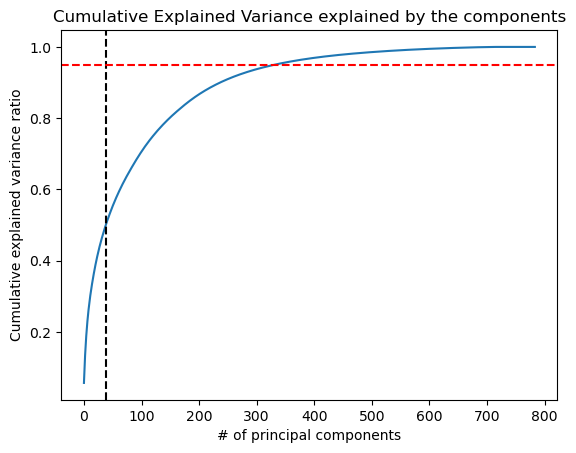

In [4]:
cum_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cum_explained_variance_ratio >= 0.50)
print(f"Number of components explaining 95% variance: {d}")

fig, ax = plt.subplots()
ax.plot(np.arange(len(cum_explained_variance_ratio)), cum_explained_variance_ratio)
plt.axvline(x = d, color="k", linestyle="--")
ax.axhline(y = 0.95, color="r", linestyle="--")
ax.set_title("Cumulative Explained Variance explained by the components")
ax.set_xlabel("# of principal components")
ax.set_ylabel("Cumulative explained variance ratio")
plt.show()

## Creating the dataset

In [5]:
rng = np.random.default_rng(547)
labels = np.unique(y_all)
X_bal = []
y_bal = []
for label in labels:
    label_idx = np.argwhere(y_all == label).reshape(-1)
    X_label = X_all[label_idx]
    y_label = y_all[label_idx]
    sample_idx = rng.choice(len(label_idx), size=5000, replace=False)
    X_bal.append(X_label[sample_idx])
    y_bal.append(y_label[sample_idx])
X_bal = np.concatenate(X_bal)
y_bal = np.concatenate(y_bal)

In [6]:
shuffle_idx = rng.choice(len(y_bal), size=len(y_bal), replace=False)
X = X_bal[shuffle_idx].reshape(len(shuffle_idx), -1)
y = y_bal[shuffle_idx]

In [7]:
X = PCA(d).fit_transform(X)
X = Normalizer().fit_transform(X)

In [8]:
def phi(c, i):
    e_i = np.zeros(10)
    e_i[i] = 1
    return (np.outer(c, e_i)).reshape(-1)

## Explore-Then-Commit

### Model the world

In [9]:
def ETC_world(tau, X, y, rng):
    T = len(y)
    action_history = np.zeros(T)

    # explore
    actions = rng.choice(10, tau, replace=True)
    action_history[:tau] = actions
    R_tau = (actions == y[:tau]).astype(int)

    C_tau = X[:tau]
    A_tau = np.zeros((tau, 10))
    A_tau[np.arange(tau), actions] = 1
    Phi_tau = np.einsum("ij,ik->ijk", C_tau, A_tau).reshape(tau, -1)

    theta_hat = np.linalg.solve(Phi_tau.T @ Phi_tau, Phi_tau.T @ R_tau)

    # commit
    for t in range(tau, T):
        C_t = np.repeat(X[[t]], repeats=10, axis=0)
        A_t = np.eye(10)
        Phi_t = np.einsum("ij,ik->ijk", C_t, A_t).reshape(10, -1)
        a_t = np.argmax(Phi_t @ theta_hat)
        action_history[t] = a_t

    return action_history

c:\Users\Wenhao\miniconda3\envs\cse-541\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


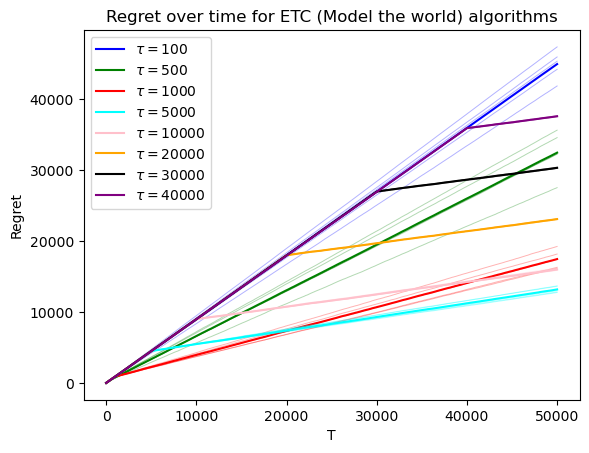

In [10]:
rng = np.random.default_rng(547)

color = ["blue", "green", "red", "cyan", "pink", "orange", "black", "purple"]
tau_range = [100, 500, 1000, 5000, 10000, 20000, 30000, 40000]

fig, ax = plt.subplots()
for i in range(len(tau_range)):
    tau = tau_range[i]
    regrets = []
    for _ in range(5):
        action_history = ETC_world(tau, X.copy(), y.copy(), rng)
        regret = np.cumsum(y != action_history)
        regrets.append(regret)
        ax.plot(range(len(regret)), regret, color=color[i], alpha=0.3, linewidth=0.7)
    regert_avg = np.mean(np.array(regrets), axis=0)
    ax.plot(range(len(regert_avg)), regert_avg, color=color[i], label=rf"$\tau = {tau}$")

ax.set_xlabel("T")
ax.set_ylabel("Regret")
ax.set_title("Regret over time for ETC (Model the world) algorithms")
ax.legend()
fig.show()

From the plot above, we should select $\tau = 10000$ ("Model the world").

### Model the bias

In [11]:
from sklearn.linear_model import LogisticRegression

def ETC_bias(tau, X, y, rng):
    T = len(y)
    action_history = np.zeros(T)

    actions = rng.choice(10, tau, replace=True)
    action_history[:tau] = actions
    mask = (actions == y[:tau])
    C_tau = X[:tau][mask]
    A_tau = actions[mask]

    model = LogisticRegression().fit(C_tau, A_tau)

    action_history[tau:] = model.predict(X[tau:])

    return action_history

c:\Users\Wenhao\miniconda3\envs\cse-541\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


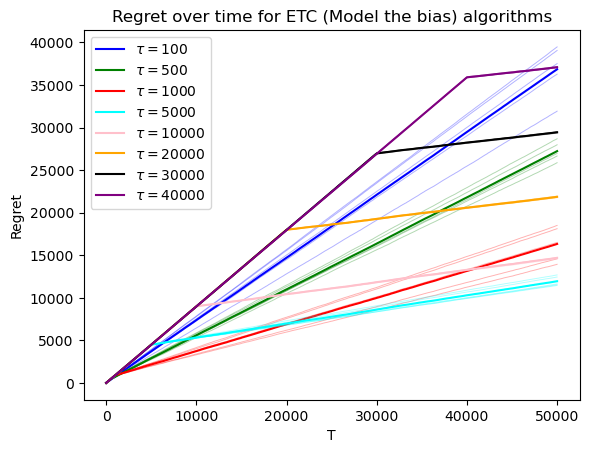

In [12]:
rng = np.random.default_rng(547)

color = ["blue", "green", "red", "cyan", "pink", "orange", "black", "purple"]
tau_range = [100, 500, 1000, 5000, 10000, 20000, 30000, 40000]

fig, ax = plt.subplots()
for i in range(len(tau_range)):
    tau = tau_range[i]
    regrets = []
    for _ in range(5):
        action_history = ETC_bias(tau, X.copy(), y.copy(), rng)
        regret = np.cumsum(y != action_history)
        regrets.append(regret)
        ax.plot(range(len(regret)), regret, color=color[i], alpha=0.3, linewidth=0.7)
    regert_avg = np.mean(np.array(regrets), axis=0)
    ax.plot(range(len(regert_avg)), regert_avg, color=color[i], label=rf"$\tau = {tau}$")

ax.set_xlabel("T")
ax.set_ylabel("Regret")
ax.set_title("Regret over time for ETC (Model the bias) algorithms")
ax.legend()
fig.show()

From the plot above, we should select $\tau = 5000$ for ETC ("Model the bias").

## Follow-The-Leader

In [15]:
def FTL(tau, X, y, rng):
    T = len(y)
    action_history = np.zeros(T)
    actions = rng.choice(10, tau, replace=True)
    action_history[:tau] = actions
    
    for t in range(tau, T):
        R_t = (action_history[:t] == y[:t]).astype(int)

        C_t = X[:t]
        A_t = np.zeros((t, 10))
        A_t[np.arange(t), action_history[:t].astype(int)] = 1
        Phi_t = np.einsum("ij,ik->ijk", C_t, A_t).reshape(t, -1)

        # theta_hat = np.linalg.solve(Phi_t.T @ Phi_t, Phi_t.T @ R_t)
        theta_hat = np.linalg.lstsq(Phi_t, R_t)[0]

        C_t = np.repeat(X[[t]], repeats=10, axis=0)
        A_t = np.eye(10)
        Phi_t = np.einsum("ij,ik->ijk", C_t, A_t).reshape(10, -1)
        a_t = np.argmax(Phi_t @ theta_hat)
        action_history[t] = a_t

        # if (t % 100 == 0):
        #     print(t)

    return action_history

c:\Users\Wenhao\miniconda3\envs\cse-541\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


KeyboardInterrupt: 

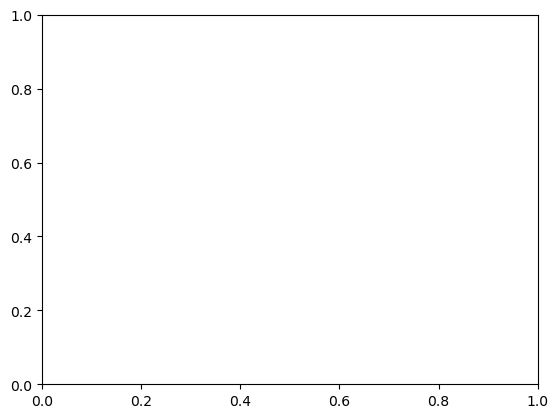

In [16]:
rng = np.random.default_rng(547)

color = ["blue", "green", "red", "cyan", "pink", "orange", "black", "purple"]
tau_range = [100, 500, 1000, 5000, 10000, 20000, 30000, 40000]

fig, ax = plt.subplots()
for i in range(len(tau_range)):
    tau = tau_range[i]
    regrets = []
    for _ in range(1):
        action_history = FTL(tau, X.copy(), y.copy(), rng)
        regret = np.cumsum(y != action_history)
        regrets.append(regret)
        ax.plot(range(len(regret)), regret, color=color[i], alpha=0.3, linewidth=0.7)
    regert_avg = np.mean(np.array(regrets), axis=0)
    ax.plot(range(len(regert_avg)), regert_avg, color=color[i], label=rf"$\tau = {tau}$")

ax.set_xlabel("T")
ax.set_ylabel("Regret")
ax.set_title("Regret over time for FTL algorithms")
ax.legend()
fig.show()

From the plot above, we should select $\tau = 5000$ for FTL ("Model the bias").

## LinUCB

## Thompson Sampling

In [20]:
rng = np.random.default_rng(547)

t = 0

theta_hat_prev = np.zeros(10 * d)
V_prev = np.eye(10 * d)
V_prev_inv = np.eye(10 * d)

theta_tilde_curr = rng.multivariate_normal(theta_hat_prev, V_prev_inv)

In [21]:
C_t = np.repeat(X[[t]], repeats=10, axis=0)
A_t = np.eye(10)
Phi_t = np.einsum("ij,ik->ijk", C_t, A_t).reshape(10, -1)
a_t = np.argmax(Phi_t @ theta_tilde_curr)
# action_history[t] = a_t

In [31]:
np.equal(Phi_t, np.outer(C_t, A_t))

ValueError: operands could not be broadcast together with shapes (10,380) (380,100) 

In [22]:
a_t

6

In [23]:
t = 1

In [27]:
phi_prev = phi(X[t - 1], a_t).reshape(-1, 1)

In [29]:
V_prev_inv = V_prev_inv - (V_prev_inv @ phi_prev @ phi_prev.T @ V_prev_inv) / (1 + phi_prev.T @ V_prev_inv @ phi_prev)

In [30]:
V_prev_inv

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])